In [2]:

# experimental mp data from OCHEM

import os
import xlrd
import pandas as pd
import numpy as np
from Util import *
from periodictable import elements


In [3]:
#m=smile_to_mol("CCSC([C@H](C1)N(C)[C@@H]2CC1=O)[C@H]2O") #test
dfexcel = pd.read_excel(r"./melting_point_ochem_training_.xls")

In [4]:
df=pd.DataFrame(dfexcel['SMILES'])
df.rename(columns={'SMILES':'Smiles'},inplace = True)
df['mp']=pd.DataFrame(dfexcel['Melting Point {measured, converted}'])


In [6]:
# read file and convert to 3d-mol save to pkl.
df['m']=apply_parallel(df['Smiles'],smile_to_mol_df)             # apply_parallel smile_to_mol 
df.to_pickle("./temp_mp.pkl")

In [7]:
df=pd.read_pickle("./temp_mp.pkl")

In [8]:
df.dropna(subset=["mp","Smiles"],inplace=True)               # drop invaild data
df['m_text']=df['m'].apply(mol_to_text)
df['coord']=df['m_text'].apply(get_coordinate)               # get coordinate 
df['cm']=df['coord'].apply(coulomb_matrix)                   # get coulomb_matrix
df.dropna(subset=["cm"],inplace=True)                        # drop invaild data


In [9]:
# normalize & resize coulomb_matrix 
df['cm_length']=df['cm'].apply(len)
df['cm_norm']=df['cm']/max_num(df['cm'])
len_max=df['cm_length'].max()
df['cm_resize']=df['cm_norm'].apply(lambda x: vec_resize(x,len_max))

In [ ]:
# convert obj to df for tf
x_train=[]
for i in df['cm_resize']:
    x_train.append(i)
dataset_all=pd.DataFrame(x_train)
dataset_all['mp']=df['mp']
dataset_all.dropna(inplace=True)
dataset_all.reset_index(drop=True)

In [12]:
train_data=dataset_all.sample(frac=0.9,random_state=0)
test_data=dataset_all.drop(train_data.index)

train_labels=train_data.pop('mp')

train_data=train_data.reset_index(drop=True)
train_labels=train_labels.reset_index(drop=True)

test_labels=test_data.pop(('mp'))




In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [39]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_data.keys())]),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
         ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [40]:
model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                10048     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 12,161
Trainable params: 12,161
Non-trainable params: 0
_________________________________________________________________


In [24]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 200

history = model.fit(
  train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................

In [28]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
195,6748.360840,65.502304,6748.360840,6934.926758,66.241356,6934.926758,195
196,6745.574219,65.435539,6745.574219,6930.555176,66.186035,6930.555176,196
197,6748.880859,65.480446,6748.880859,6929.506836,66.238976,6929.506836,197
198,6740.407227,65.414368,6740.407227,6925.238281,66.220627,6925.238281,198
199,6745.177246,65.389275,6745.177246,6940.420898,66.334236,6940.420898,199


In [29]:
import matplotlib.pyplot as plt
    

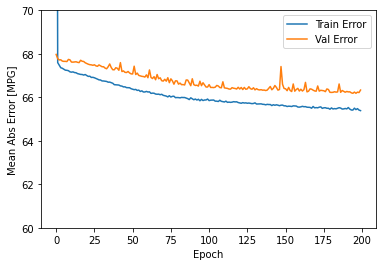

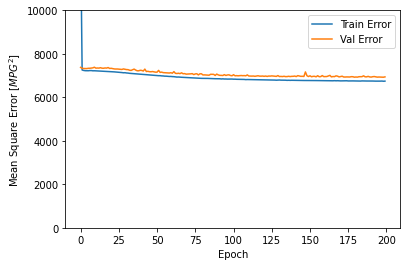

In [37]:
def plot_history(history):
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Mean Abs Error [MPG]')
      plt.plot(hist['epoch'], hist['mae'],
               label='Train Error')
      plt.plot(hist['epoch'], hist['val_mae'],
               label = 'Val Error')
      plt.ylim([60,70])
      plt.legend()

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Mean Square Error [$MPG^2$]')
      plt.plot(hist['epoch'], hist['mse'],
               label='Train Error')
      plt.plot(hist['epoch'], hist['val_mse'],
               label = 'Val Error')
      plt.ylim([0,10000])
      plt.legend()
      plt.show()


plot_history(history)